In [48]:
import os
import copy
import pickle
import numpy as np
import pandas as pd
from tqdm import trange
from scipy.optimize import curve_fit

import shapely
import matplotlib.pyplot as plt

import mdtraj

import sys
sys.path.append(os.path.abspath("../../nnprotscan"))
import mdmetric

In [68]:
OUTPUT_PATH = "../glp1-md-analysis"
ACYL_RESIDS = [14, 15, 16, 18, 19, 20, 22, 23, 26, 27, 30, 31, 33, 34, 35, 36]
GLP1_SEQUENCE = "HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR"

METRICS_DICT = {
    "membrane_thickness": "membrane_t", 
    "protractor_rg": "rg",
    "protractor_ree": "ree",
    "protractor_receptor_contacts": "prc",
    "protractor_peptide_contacts": "ppc",
    "protractor_membrane_contacts": "pmc",
    "peptide_rmsd": "rmsd",
    "protractor_receptor_coul_energy": "pr_coul",
    "protractor_peptide_coul_energy": "pp_coul",
    "protractor_membrane_coul_energy": "pm_coul",
    "protractor_receptor_lj_energy": "pr_lj",
    "protractor_peptide_lj_energy": "pp_lj",
    "protractor_membrane_lj_energy": "pm_lj"
}


TRANSFORMED_METRICS_DICT = {
    "inv_rg": "$R_g^{-1}$",
    "inv_ree": "$R_{ee}^{-1}$",
    "prc": "$C_\mathrm{pr}$",
    "ppc": "$C_\mathrm{pp}$",
    "pmc": "$C_\mathrm{pm}$",
    "rmsd": "$\mathrm{rmsd}_p$"
}

TRANSFORMED_METRICS_DICT.update({
    "pr_coul": "$U_{pr}^\mathrm{Coul}$",
    "pp_coul": "$U_{pp}^\mathrm{Coul}$",
    "pm_coul": "$U_{pm}^\mathrm{Coul}$",
    "pr_lj": "$U_{pr}^\mathrm{LJ}$",
    "pp_lj": "$U_{pp}^\mathrm{LJ}$",
    "pm_lj": "$U_{pm}^\mathrm{LJ}$",
})

## Combine all data into a dataframe
(store rmsf s separately)

In [69]:
df = []
rmsf = {}

for r in ACYL_RESIDS:
    pkl_file = os.path.join(OUTPUT_PATH, "K" + str(r), "metrics.pkl")
    with open(pkl_file, "rb") as of:
        metrics = pickle.load(of)
    df.append([r] + [metrics[k][0] for k in METRICS_DICT])
    rmsf[r] = metrics["peptide_rmsf"]
df = pd.DataFrame(df, columns = ["acyl_resid"] + [METRICS_DICT[k] for k in METRICS_DICT])
display(df)

,acyl_resid,membrane_t,rg,ree,prc,ppc,pmc,rmsd,pr_coul,pp_coul,pm_coul,pr_lj,pp_lj,pm_lj
0,14,3.830638,0.807436,2.242365,656.455384,308.379171,441.155460,0.267686,-137.789961,-427.034759,-71.005602,-155.038041,-82.387870,-87.204856
1,15,3.832138,0.725977,1.447346,790.170103,515.765405,200.851103,0.405350,-178.690235,-516.450996,-35.282532,-185.426194,-102.557420,-38.289126
2,16,3.834288,0.885069,2.700833,539.737699,667.202414,82.527323,0.442418,-94.041280,-468.582574,-58.925818,-129.477359,-149.089062,-22.190548
3,18,3.829100,0.990681,2.855626,621.352769,176.086781,753.729744,0.377962,-88.152245,-434.703599,-111.618940,-149.826284,-47.499032,-148.524982
4,19,3.831937,0.755408,2.102310,726.835965,403.158213,141.668733,0.364694,-175.484302,-436.519931,-33.409595,-163.879719,-93.042140,-29.512844
5,20,3.830842,0.905835,2.535868,643.668427,406.910426,664.181772,0.399512,-94.625107,-443.778516,-99.922413,-145.598599,-89.980636,-130.081823
6,22,3.829774,0.827702,1.921688,613.703577,697.435718,393.871213,0.423956,-159.561947,-470.012141,-64.377459,-138.904749,-163.637040,-85.002858
7,23,3.834000,0.803002,2.157278,612.902181,852.021808,122.036504,0.455800,-116.840068,-530.916861,-20.766261,-139.502745,-186.802407,-24.831018
8,26,3.828097,0.848827,2.119079,748.418024,424.915533,78.921942,0.262414,-168.735210,-540.854040,-13.552017,-159.591303,-110.252931,-15.266155
9,27,3.827208,0.867246,2.181463,583.724736,684.408244,166.279472,0.537082,-146.060218,-483.148045,-22.235761,-132.863196,-150.515706,-32.378642


We see that the membrane thickness ~ 3.8 nm across all simulations which is consistent with a DPCC membrane. We shall drop this quantity from further analyses. 

In [51]:
df = df.drop("membrane_t", axis=1)

# Normalization
First we transform $R_g$ and $R_{ee}$ of protactor to $1/R_g$ and $1/R_{ee}$, such that a better acylation residue will have lower values for these properties, similar to the other properties.<br>

We transform data in each column ($x$) to a (0,1) domain ($y$) using a sigmoid function with unknown slope, ie.  $y = 1/(1+\exp \left( -k(x-x_0)\right)$, where $x_0$ is taken as the mean of data in that column. Say the resulting data is transformed to the range $[y_{min}, y_{max}] \in (0,1)$. If we know $y_{min}, y_{max}$, we can estimate the slope $k$ as:
$$k = - \frac{1}{x_{max} - x_{min}} \:\: \log \left( \frac{1-y_{max}}{1-y_{min}} \right)$$

Here we use $y_{min} = 0.001$ and $y_{max}$ = 0.999.

In [52]:
def _invert(x):
    # out = 1 / (1+x)
    out = 1 / (1e-9 + x)
    # out = -x
    return out
    
def _normalize(x):
    out = (x - x.min()) / (x.max() - x.min())
    #out = (x-x.mean()) / x.std()
    
    ymin, ymax = 0.001, 0.999
    slope = -np.log((1 - ymax)/(1 - ymin)) / (np.max(x) - np.min(x))
    out = 1 / (1 + np.exp(-slope * (x - np.mean(x))))
    
    return out

In [53]:
df_transformed = copy.copy(df)
df_transformed.iloc[:, 1:3] = df_transformed.iloc[:, 1:3].apply(_invert, axis=0)  
df_transformed.iloc[:,1:] = df_transformed.iloc[:,1:].apply(_normalize, axis=0)  
df_transformed = df_transformed.rename(columns={"rg":"inv_rg", "ree": "inv_ree"})
display(df_transformed)

,acyl_resid,inv_rg,inv_ree,prc,ppc,pmc,rmsd,pr_coul,pp_coul,pm_coul,pr_lj,pp_lj,pm_lj
0,14,0.766563,0.517961,0.352922,0.149751,0.889671,0.045213,0.556800,0.891032,0.121656,0.579416,0.824773,0.113281
1,15,0.966027,0.986506,0.727830,0.375914,0.466980,0.287534,0.109303,0.275805,0.566948,0.209514,0.728483,0.560151
2,16,0.377914,0.225785,0.119836,0.596516,0.227020,0.418133,0.937978,0.662928,0.228417,0.846417,0.423161,0.730771
3,18,0.085537,0.171076,0.264329,0.074404,0.993136,0.208550,0.954833,0.862749,0.010659,0.646356,0.925622,0.007102
4,19,0.925117,0.641917,0.557396,0.236026,0.336500,0.176507,0.128359,0.855205,0.595604,0.460286,0.777665,0.657985
5,20,0.288893,0.306332,0.319025,0.240061,0.984441,0.269283,0.936018,0.821577,0.021986,0.696855,0.792067,0.016738
6,22,0.672161,0.794768,0.247026,0.638815,0.838976,0.350283,0.266976,0.651886,0.173637,0.767712,0.328443,0.124102
7,23,0.785034,0.592642,0.245258,0.815596,0.297282,0.469501,0.805282,0.188238,0.765341,0.761878,0.204109,0.705663
8,26,0.562405,0.626879,0.619449,0.260073,0.221230,0.041799,0.177742,0.141570,0.836965,0.518344,0.684057,0.789853
9,27,0.465622,0.571105,0.186793,0.620809,0.388979,0.758229,0.439755,0.544090,0.748342,0.820998,0.413487,0.627057


## Radar plots

In [54]:
def make_single_radar_plot(acyl_resid, ax, metrics=[], title=""):
    df_t = df_transformed[df_transformed["acyl_resid"] == acyl_resid]
    
    if not metrics:
        metrics = sorted(list(TRANSFORMED_METRICS_DICT.keys()))
    
    # create X axes
    angles = [i / float(len(metrics)) * 2 * np.pi for i in range(len(metrics))]
    angles += angles[:1]
    
    # set X axes offsets
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    metric_labels = [TRANSFORMED_METRICS_DICT[k] for k in metrics]
    ax.set_thetagrids(np.degrees(angles), metric_labels + metric_labels[:1], fontsize=20)
    
    # make xlabels pretty
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment("center")
        elif 0 < angle < np.pi:
            label.set_horizontalalignment("left")
        else:
            label.set_horizontalalignment("right")
    
    ax.set_rlabel_position(180/len(metrics))
    
    # create Y axes
    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(yticks, [str(y) for y in yticks], size=15)
    ax.set_ylim([0, 1])
    
    # load values
    values = [df_t[k] for k in metrics]
    values += values[:1]
    values = np.array(values).flatten().tolist()
    
    # plot the data
    ax.plot(angles, values, ls="solid", lw=2, color="navy")
    ax.fill(angles, values, alpha=0.2)
    
    if title:
        ax.set_title(title, fontsize=25)
    
    # calculate area under the radar plot
    xcoords = np.array(values[:-1]) * np.cos(angles[:-1])
    ycoords = np.array(values[:-1]) * np.sin(angles[:-1])
    area = shapely.geometry.MultiPoint(list(zip(xcoords.tolist(), ycoords.tolist()))).convex_hull.area
    return area

We include radar plots for acylation residues 19, 26, 33, 36

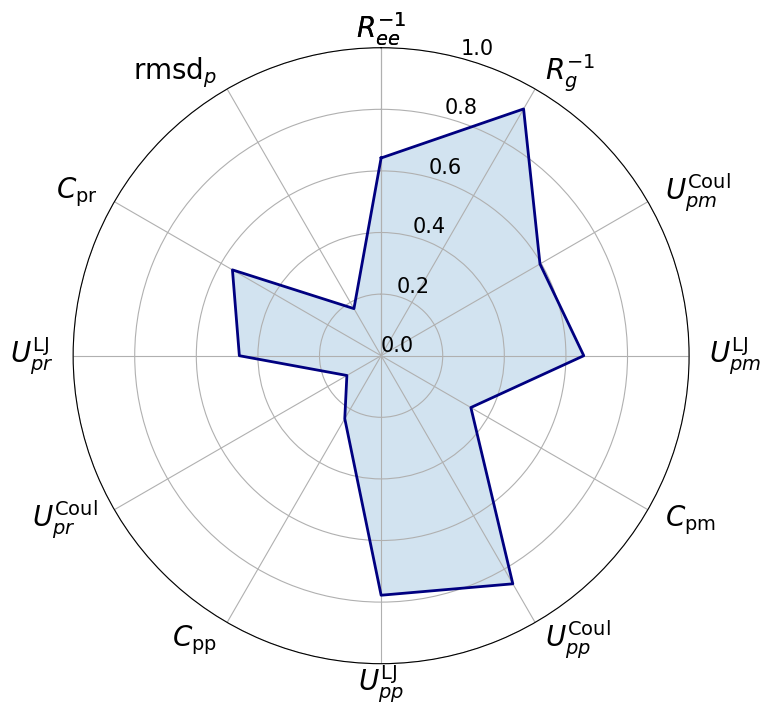

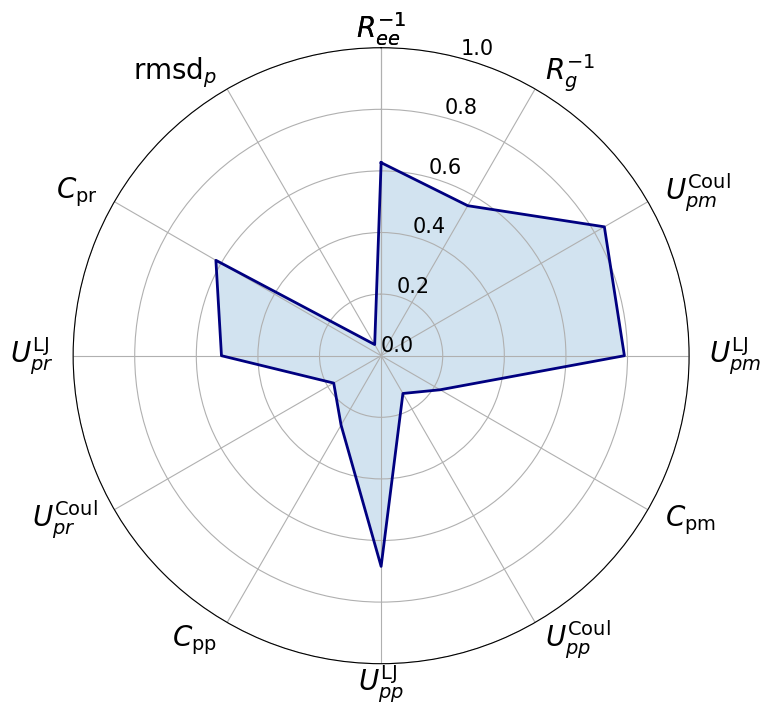

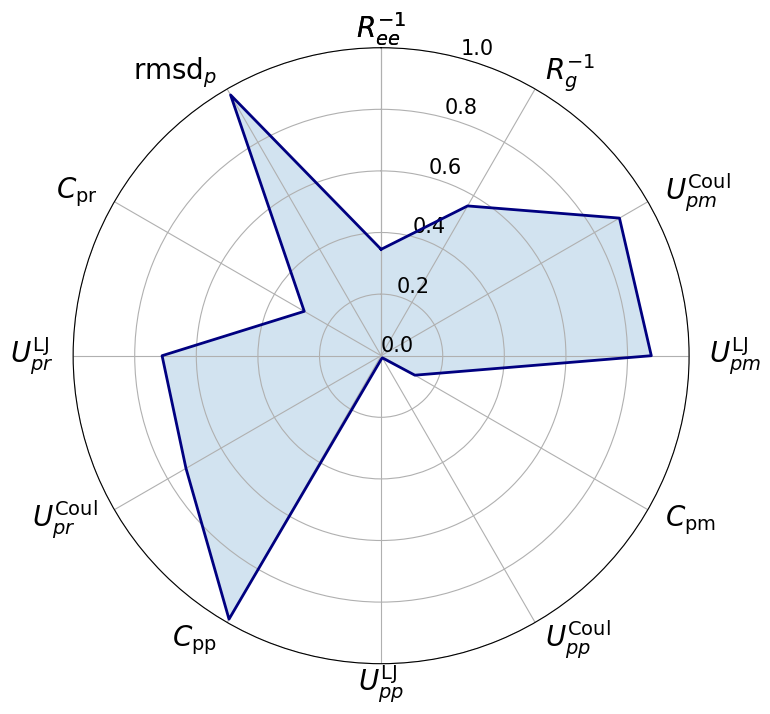

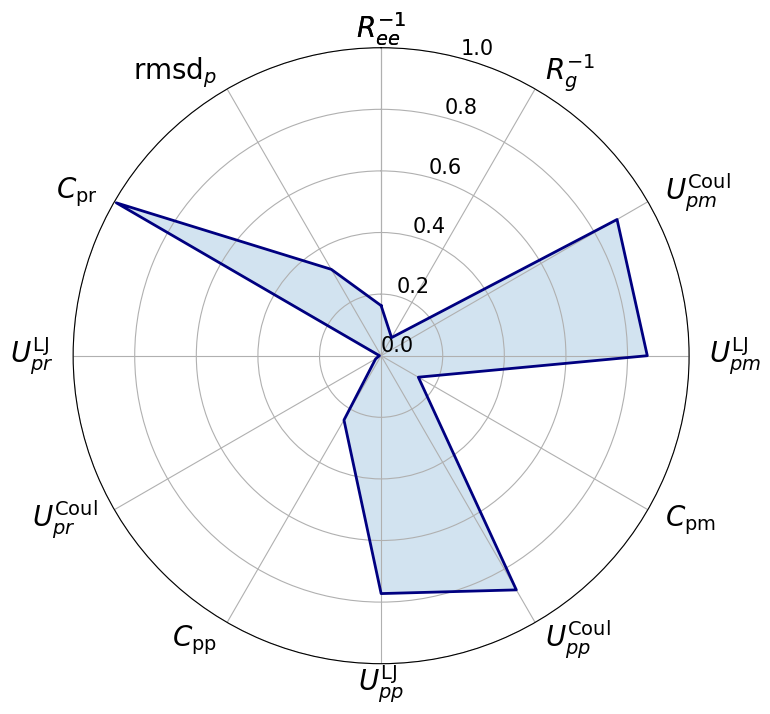

In [59]:
for r in [19, 26, 33, 36]:
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1, polar=True)
    make_single_radar_plot(r, ax, title="")
    figname = f"figures/radar_plot_acyl_res-{r}.png"
    fig.savefig(figname, dpi=200, bbox_inches="tight")

## Radar plots for all residues in this study

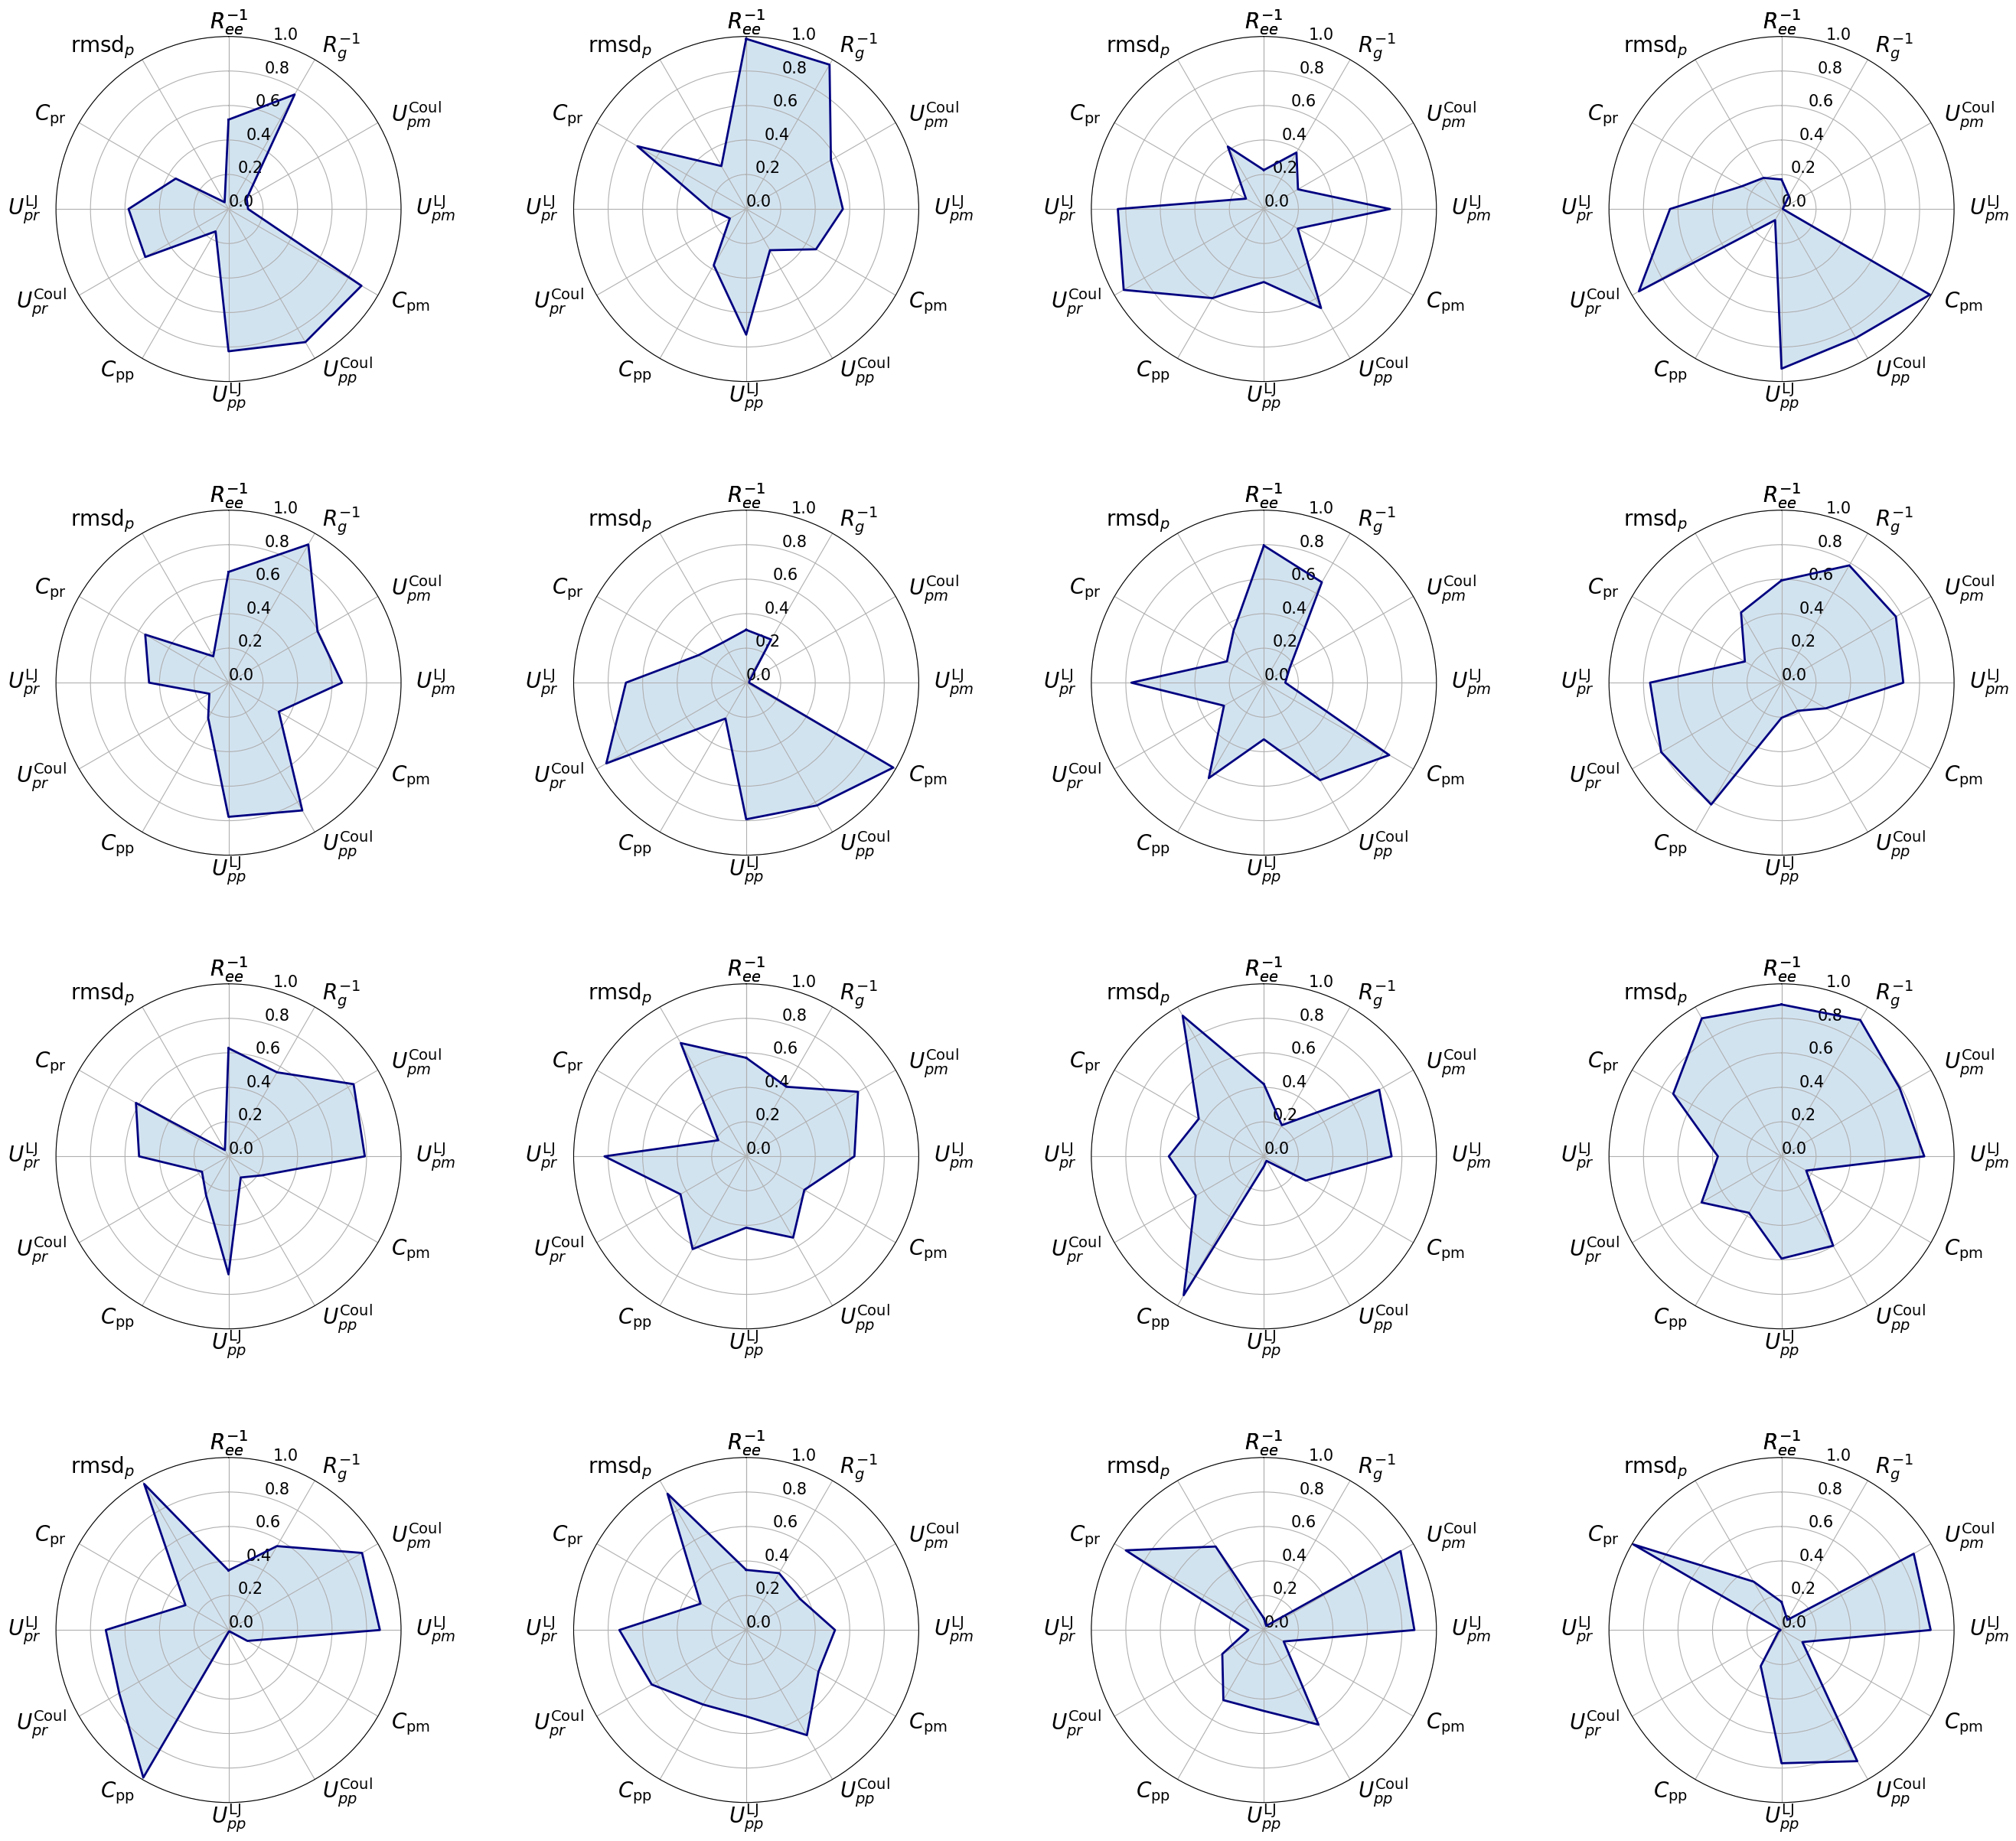

In [61]:
def make_array_radar_plot(acyl_resids, metrics=[], ncols=4):
    areas = []
    nrows = int(len(acyl_resids) / ncols)
    if len(acyl_resids) % ncols:
        nrows += 1
        
    fig = plt.figure(figsize=(8*ncols, 8*nrows))
    for i, r in enumerate(acyl_resids):
        ax = fig.add_subplot(nrows, ncols, i+1, polar=True)
        #title = GLP1_SEQUENCE[r-7] + str(r)
        title = ""
        a = make_single_radar_plot(r, ax, metrics=metrics, title=title)
        areas.append(a)
    
    fig.subplots_adjust(hspace=0.02, wspace=0.5)
    figname = "figures/radar_plot_all.png"
    fig.savefig(figname, dpi=200, bbox_inches="tight")
    return areas
    
areas = make_array_radar_plot(ACYL_RESIDS)

# Total shaded area under the radar plot as a figure of merit

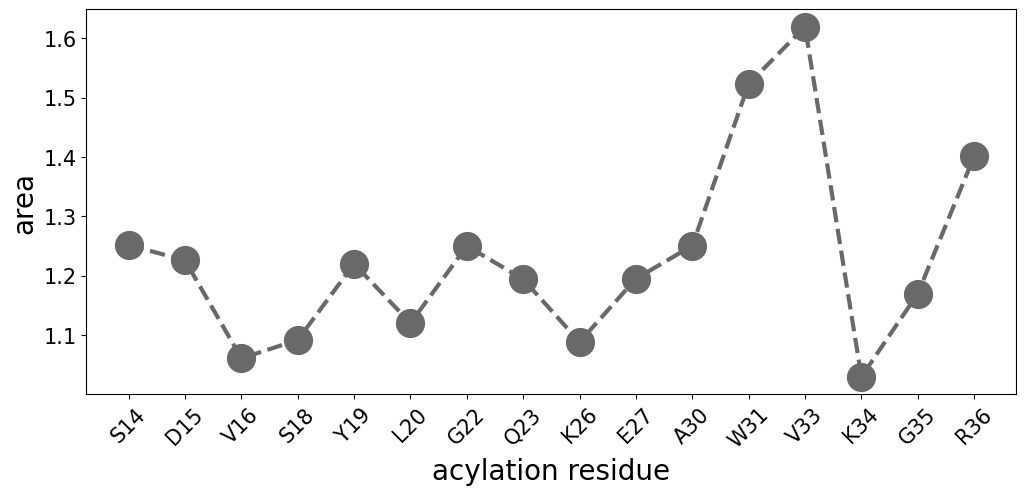

In [101]:
xticks = range(len(ACYL_RESIDS))
xlabels = [GLP1_SEQUENCE[r-7] + str(r) for r in ACYL_RESIDS]

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(xticks, areas, color="dimgrey", ls="--", marker="o", lw=3, markersize=20)

ax.set_xticks(xticks, xlabels, rotation=45);
ax.tick_params(axis="both", labelsize=15)
ax.set_xlabel("acylation residue", fontsize=20)
ax.set_ylabel("area", fontsize=20);


figname = "figures/radar_plot_area.png"
fig.savefig(figname, dpi=200, bbox_inches="tight")

# RMS fluctuations per residue for different residues 

In [102]:
def plot_rmsf(acyl_resids, colors):
    xvals = list(range(7, 7 + len(GLP1_SEQUENCE)))
    max_rmsf_resids = []
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,1,1)
    
    for (r, c) in zip(acyl_resids, colors):
        label = GLP1_SEQUENCE[r-7] + str(r)
        if GLP1_SEQUENCE[r-7] != "K": label += "K"  
        ax.plot(xvals, rmsf[r] * 10, ls="-", marker="o", lw=3, markersize=10, color=c, label=label, alpha=0.8)
        
        max_rmsf_resids.append(int(7 + np.argmax(rmsf[r])))
    
    ax.tick_params(axis="both", labelsize=15)
    ax.legend(loc="best", prop={"size": 15})
    ax.set_xlabel("residue", fontsize=20)
    ax.set_ylabel("rms fluctuation " + "$(\AA)$", fontsize=20)
    
    figname = "figures/rmsf_comparison.png"
    fig.savefig(figname, dpi=200, bbox_inches="tight")
    
    return max_rmsf_resids

acyl residue =  19 max rmsf residue =  15
acyl residue =  26 max rmsf residue =  36
acyl residue =  33 max rmsf residue =  31
acyl residue =  36 max rmsf residue =  35


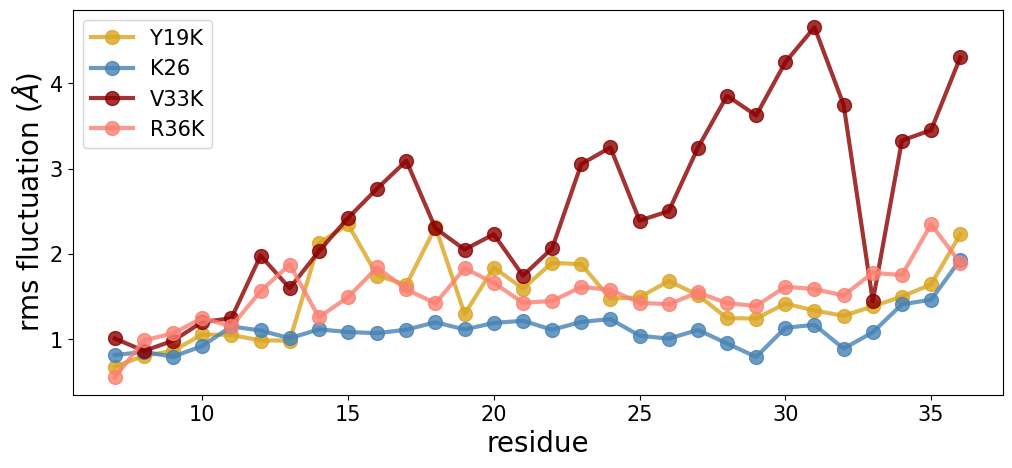

In [103]:
acyl_resids=[19, 26, 33, 36]
max_rmsf_resids = plot_rmsf(acyl_resids = acyl_resids, colors=["goldenrod", "steelblue", "darkred", "salmon"])

for (r1, r2) in zip (acyl_resids, max_rmsf_resids):
    print("acyl residue = ", r1, "max rmsf residue = ", r2)